In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'

# Ytrain in Onehot encoded form 
def makeOverSamplesSMOTE(X_train,Y_train):
    
    Y_train_labelled=[]
    X_dims=X_train.shape

    for i in range(len(Y_train)):
        Y_train_labelled.append(np.argmax(Y_train[i]))

    print('Original trainingset shape %s' %  [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])       
    X_train= X_train.reshape(-1,X_dims[1]*X_dims[2]*X_dims[3])

    sm = SMOTE(sampling_strategy='all',k_neighbors=5)
    X_train, Y_train_labelled = sm.fit_resample(X_train, Y_train_labelled)


    print('Resampled training set shape %s' % [(getSpecies(k),v) for k,v in Counter(Y_train_labelled).items()])


    #reshape X_all
    X_train= X_train.reshape(-1,X_dims[1],X_dims[2],X_dims[3])

    # update Y_train
    Y_train= np_utils.to_categorical(Y_train_labelled, num_classes=8)

    print("After OverSampling\nX_train: shape= ",X_train.shape)
    print("Y_train: shape= ",Y_train.shape)

    
    
    return(X_train,Y_train)

In [4]:
image_folder_path = '../data/MFCCRefined'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/MFCCRefined'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('L')
    spectrogram = spectrogram.resize((341, 224))  
    spectrogram = np.array(spectrogram)
    spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 224, 341, 1)
(3018,)


In [12]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


X_train, Y_train= makeOverSamplesSMOTE(X_train, Y_train)

Original trainingset shape [('RHYNAS', 217), ('EPTBOT', 105), ('RHIMUS', 1439), ('TAPPER', 343), ('ASETRI', 20), ('PIPKUH', 242), ('MYOEMA', 91), ('ROUAEG', 97)]
Resampled training set shape [('RHYNAS', 1439), ('EPTBOT', 1439), ('RHIMUS', 1439), ('TAPPER', 1439), ('ASETRI', 1439), ('PIPKUH', 1439), ('MYOEMA', 1439), ('ROUAEG', 1439)]
After OverSampling
X_train: shape=  (11512, 224, 341, 3)
Y_train: shape=  (11512, 8)


<h2>Model Building</h2>

In [16]:

   def build_current_model():
    inp = Input(shape=(224,341,1))
    
    c1 = Convolution2D(filters=128,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)

    
    c2 = Convolution2D(filters=256,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.4)(mpool)
    
    f = Flatten()(mpool)
    
    x_dense = Dense(2048)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)

    
    x_dense = Dense(1024)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)
    
    x_dense = Dense(512)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(8, name='output', activation='softmax')(bt)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.003), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model




In [15]:
model = build_current_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 341, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 171, 128)     18944     
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 171, 128)     512       
_________________________________________________________________
activation_7 (Activation)    (None, 112, 171, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 86, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 56, 86, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 43, 256)       8194

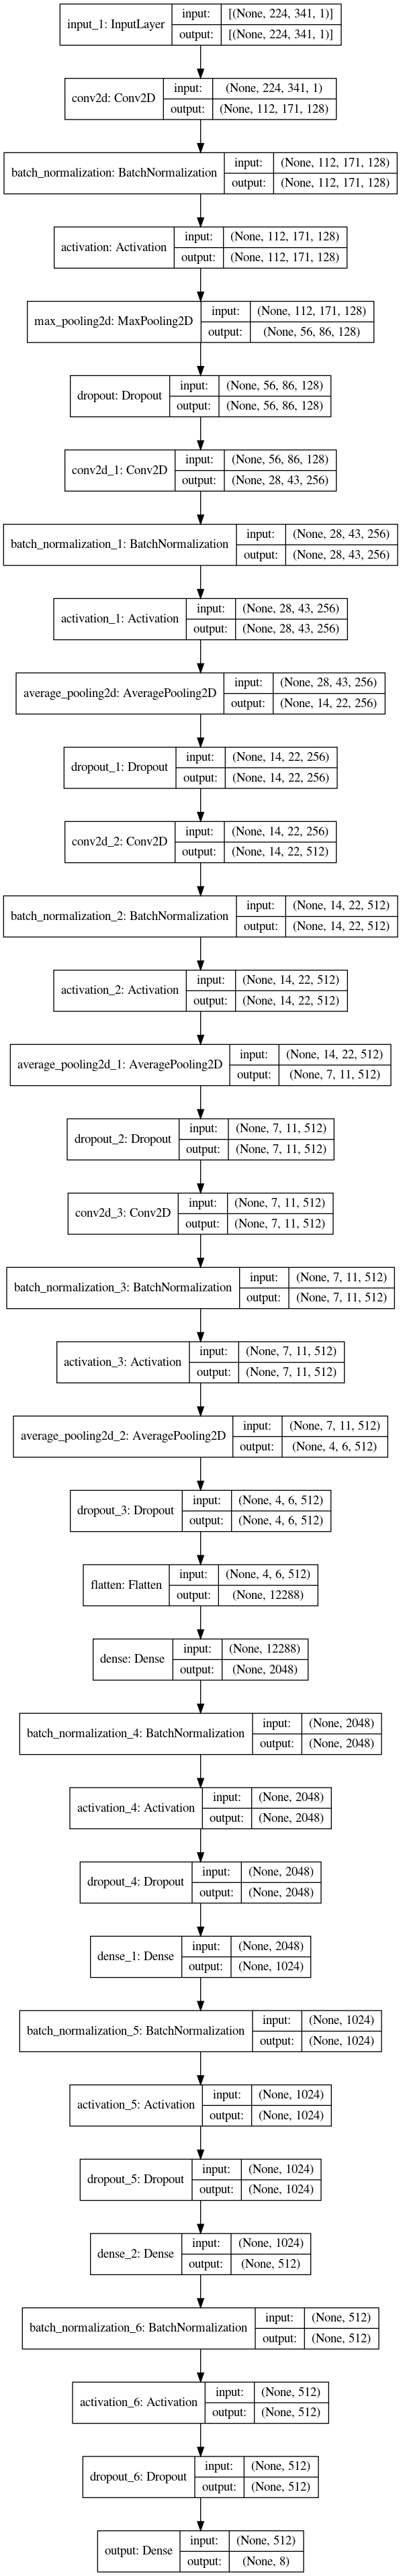

In [24]:
tf.keras.utils.plot_model(model, "Model2V8.png", show_shapes=True)

In [16]:

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=25,verbose=1, mode='min',restore_best_weights=True)]

history = model.fit(X_train, Y_train, 
              epochs = 100, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
#             class_weight = class_weight
                 callbacks=my_callbacks   )

history_info = history.history



Train on 10360 samples, validate on 1152 samples
Epoch 1/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 1.1303 - acc: 0.6219 - val_loss: 4.0711 - val_acc: 0.1276
Epoch 2/100
10360/10360 [==============================] - 47s 5ms/sample - loss: 0.6060 - acc: 0.7862 - val_loss: 2.1862 - val_acc: 0.2795
Epoch 3/100
10360/10360 [==============================] - 47s 5ms/sample - loss: 0.4493 - acc: 0.8482 - val_loss: 3.2620 - val_acc: 0.1936
Epoch 4/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 0.3472 - acc: 0.8837 - val_loss: 1.3615 - val_acc: 0.6007
Epoch 5/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 0.3050 - acc: 0.9009 - val_loss: 0.6056 - val_acc: 0.7977
Epoch 6/100
10360/10360 [==============================] - 48s 5ms/sample - loss: 0.2411 - acc: 0.9217 - val_loss: 0.4586 - val_acc: 0.8481
Epoch 7/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.2138 - acc: 0.9294 - val_lo

Epoch 59/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0351 - acc: 0.9914 - val_loss: 0.0403 - val_acc: 0.9826
Epoch 60/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0262 - acc: 0.9924 - val_loss: 0.0069 - val_acc: 0.9974
Epoch 61/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0254 - acc: 0.9931 - val_loss: 0.0218 - val_acc: 0.9887
Epoch 62/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0230 - acc: 0.9935 - val_loss: 0.2899 - val_acc: 0.9566
Epoch 63/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0316 - acc: 0.9919 - val_loss: 0.0033 - val_acc: 0.9991
Epoch 64/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0299 - acc: 0.9917 - val_loss: 9.0945e-04 - val_acc: 1.0000
Epoch 65/100
10360/10360 [==============================] - 49s 5ms/sample - loss: 0.0205 - acc: 0.9946 - val_loss: 0.0789 - val_acc: 0.9748
Epoch 66/

<h2>Evaluation (Basic)</h2>

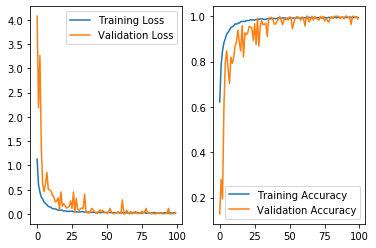

In [17]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [8]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [9]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

NameError: name 'model' is not defined

In [10]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


NameError: name 'actual' is not defined

In [11]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

NameError: name 'actual_labeled' is not defined

In [12]:
##ROC AUC Scores
from sklearn.metrics import roc_auc_score
print('One-vs-One ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


print()
print('One-vs-Rest ROC AUC scores:')
print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

One-vs-One ROC AUC scores:


NameError: name 'actual' is not defined

NameError: name 'Y_test' is not defined

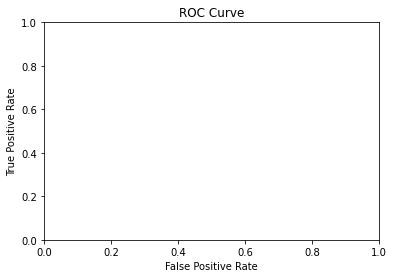

In [13]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

### ROC Curves + AUC per class

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve')

fpr = [0] * 8
tpr = [0] * 8
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:,i], Y_pred[:,i])
    auc_val = auc(fpr[i], tpr[i])
    auc_val = np.around(auc_val,4)
    sns.lineplot(x=fpr[i],y=tpr[i],ax=axs, label='Class '+ getSpecies(i) +' (area = ' + str(auc_val) + ')', legend='brief')

#### Micro/Macro ROC Curves + AUC over all classes

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(8)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(8):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 8

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)
fpr_micro, tpr_micro,_ = roc_curve(Y_test.ravel(), Y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


roc_auc_macro = np.around(roc_auc_macro,4)
roc_auc_micro = np.around(roc_auc_micro,4)
sns.lineplot(x=fpr_macro,y=tpr_macro,ax=axs, label='Macro-average ROC curve (area = ' + str(roc_auc_macro) + ')', legend='brief')
sns.lineplot(x=fpr_micro,y=tpr_micro,ax=axs, label='Micro-average ROC curve (area = ' + str(roc_auc_micro) + ')', legend='brief')

## Diagonal line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)

NameError: name 'Y_test' is not defined

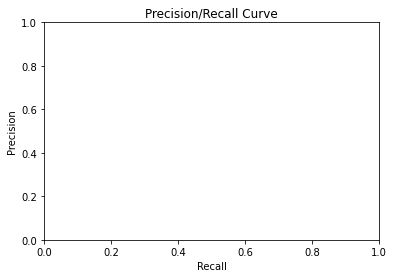

In [14]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve')

prec = [0] * 8
rec = [0] * 8
for i in range(8):
    prec[i], rec[i], _ = precision_recall_curve(Y_test[:,i], Y_pred[:,i])
    sns.lineplot(x=rec[i],y=prec[i],ax=axs, label='Class '+ getSpecies(i), legend='brief')

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [17]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
    #oversample
    x_train, y_train= makeOverSamplesSMOTE(x_train, y_train)
       
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=100,
              validation_split=0.1,
              verbose=1,
            callbacks=my_callbacks)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Original trainingset shape [('E.bottae', 99), ('R.muscatellum', 1332), ('P.kuhli', 240), ('R.nasutus', 215), ('T.perforatus', 322), ('M.emarginatus', 90), ('R.aegyptius', 96), ('A.tridens', 20)]
Resampled training set shape [('E.bottae', 1332), ('R.muscatellum', 1332), ('P.kuhli', 1332), ('R.nasutus', 1332), ('T.perforatus', 1332), ('M.emarginatus', 1332), ('R.aegyptius', 1332), ('A.tridens', 1332)]
After OverSampling
X_train: shape=  (10656, 224, 341, 1)
Y_train: shape=  (10656, 8)
Train on 9590 samples, validate on 1066 samples
Epoch 1/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 1.2134 - acc: 0.5905 - val_loss: 3.9291 - val_acc: 0.0910
Epoch 2/100
9590/9590 [==============================] - 41s 4ms/sample - loss: 0.6839 - acc: 0.7599 - val_loss: 2.5253 - val_acc: 0.1745
Epoch 3/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.4847 - acc: 0.8324 - val_loss: 1.7539 - val_acc: 0.2730
Epoch 4/100
9590/9590 [===========================

9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0302 - acc: 0.9897 - val_loss: 0.0219 - val_acc: 0.9934
Epoch 57/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0276 - acc: 0.9930 - val_loss: 0.0083 - val_acc: 0.9962
Epoch 58/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0314 - acc: 0.9913 - val_loss: 0.0299 - val_acc: 0.9916
Epoch 59/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0220 - acc: 0.9940 - val_loss: 0.0065 - val_acc: 0.9981
Epoch 60/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0214 - acc: 0.9949 - val_loss: 0.0495 - val_acc: 0.9841
Epoch 61/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0326 - acc: 0.9905 - val_loss: 0.0632 - val_acc: 0.9859
Epoch 62/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0214 - acc: 0.9934 - val_loss: 0.1278 - val_acc: 0.9475
Epoch 63/100
9590/9590 [================

9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1291 - acc: 0.9583 - val_loss: 0.1926 - val_acc: 0.9325
Epoch 12/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1165 - acc: 0.9633 - val_loss: 0.2140 - val_acc: 0.9146
Epoch 13/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1153 - acc: 0.9628 - val_loss: 0.2327 - val_acc: 0.8977
Epoch 14/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1053 - acc: 0.9656 - val_loss: 0.5177 - val_acc: 0.7983
Epoch 15/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0929 - acc: 0.9701 - val_loss: 0.2641 - val_acc: 0.9006
Epoch 16/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0918 - acc: 0.9717 - val_loss: 0.4485 - val_acc: 0.8152
Epoch 17/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0920 - acc: 0.9715 - val_loss: 0.3752 - val_acc: 0.8471
Epoch 18/100
9590/9590 [================

9590/9590 [==============================] - 42s 4ms/sample - loss: 0.2151 - acc: 0.9309 - val_loss: 0.6005 - val_acc: 0.7983
Epoch 8/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1877 - acc: 0.9422 - val_loss: 0.4455 - val_acc: 0.8583
Epoch 9/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1632 - acc: 0.9484 - val_loss: 0.9134 - val_acc: 0.6876
Epoch 10/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1503 - acc: 0.9526 - val_loss: 0.1302 - val_acc: 0.9512
Epoch 11/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1185 - acc: 0.9601 - val_loss: 0.5200 - val_acc: 0.8236
Epoch 12/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1146 - acc: 0.9616 - val_loss: 0.5463 - val_acc: 0.8471
Epoch 13/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1081 - acc: 0.9643 - val_loss: 0.3442 - val_acc: 0.8687
Epoch 14/100
9590/9590 [==================

9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0241 - acc: 0.9928 - val_loss: 0.4198 - val_acc: 0.8790
Epoch 67/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0250 - acc: 0.9920 - val_loss: 0.0190 - val_acc: 0.9972
Epoch 68/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0274 - acc: 0.9924 - val_loss: 0.0973 - val_acc: 0.9606
Epoch 69/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0240 - acc: 0.9931 - val_loss: 0.0334 - val_acc: 0.9906
Epoch 70/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0289 - acc: 0.9918 - val_loss: 0.0070 - val_acc: 0.9981
Epoch 71/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0140 - acc: 0.9960 - val_loss: 0.0197 - val_acc: 0.9925
Epoch 72/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0235 - acc: 0.9938 - val_loss: 0.0087 - val_acc: 0.9953
Epoch 73/100
9590/9590 [================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0275 - acc: 0.9922 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 50/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0351 - acc: 0.9907 - val_loss: 0.1810 - val_acc: 0.9644
Epoch 51/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0273 - acc: 0.9922 - val_loss: 0.0144 - val_acc: 0.9962
Epoch 52/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0257 - acc: 0.9924 - val_loss: 0.0330 - val_acc: 0.9859
Epoch 53/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0365 - acc: 0.9899 - val_loss: 0.0219 - val_acc: 0.9934
Epoch 54/100
5528/9590 [================>.............] - ETA: 17s - loss: 0.0203 - acc: 0.9928

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1496 - acc: 0.9541 - val_loss: 0.3814 - val_acc: 0.8537
Epoch 11/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1354 - acc: 0.9562 - val_loss: 0.2152 - val_acc: 0.9240
Epoch 12/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1053 - acc: 0.9664 - val_loss: 0.8873 - val_acc: 0.8030
Epoch 13/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.1099 - acc: 0.9674 - val_loss: 0.2499 - val_acc: 0.9231
Epoch 14/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0980 - acc: 0.9691 - val_loss: 0.3118 - val_acc: 0.8940
Epoch 15/100
8072/9590 [========================>.....] - ETA: 6s - loss: 0.1001 - acc: 0.9670

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0491 - acc: 0.9850 - val_loss: 0.3960 - val_acc: 0.8546
Epoch 30/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0424 - acc: 0.9872 - val_loss: 0.0174 - val_acc: 0.9944
Epoch 31/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0480 - acc: 0.9848 - val_loss: 0.1485 - val_acc: 0.9522
Epoch 32/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0446 - acc: 0.9880 - val_loss: 0.0506 - val_acc: 0.9812
Epoch 33/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0406 - acc: 0.9872 - val_loss: 0.1139 - val_acc: 0.9644
Epoch 34/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0463 - acc: 0.9878 - val_loss: 0.1866 - val_acc: 0.9456
Epoch 35/100
9590/9590 [==============================] - 42s 4ms/sample - loss: 0.0436 - acc: 0.9872 - val_loss: 0.2024 - val_acc: 0.9062
Epoch 36/100
9590/9590 [================

In [18]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [0.88       0.99       0.8251536  0.90142167 0.9640545  0.93108573
 0.81466387 0.88301574]
precision sdev by class [0.09797959 0.02       0.05113346 0.04781078 0.0132312  0.03490634
 0.10482934 0.0244353 ]
macro precision mean 0.8986743869456186
macro precision sdev 0.033473182728380756
recall mean [0.8        0.81433333 0.74071146 0.90983051 0.97417417 0.93675751
 0.68633333 0.94552469]
recall sdev [0.12649111 0.04157456 0.09700639 0.04279019 0.01179993 0.0094249
 0.07522116 0.03706866]
macro recall mean 0.8509581269191557
macro recall sdev 0.02044622066087264
f1 mean [0.83       0.89325359 0.7763207  0.90543869 0.96894682 0.93364311
 0.7391996  0.91239276]
f1 sdev [0.08717798 0.03074323 0.06022265 0.043567   0.00465649 0.02024136
 0.06016151 0.01542644]
macro f1 mean 0.8698994089961442
macro f1 sdev 0.021473234997264338
accuracy mean 0.9324036550141127
accuracy sdev 0.01175110469854232


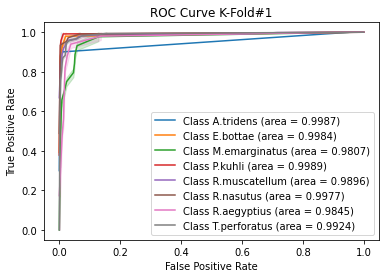

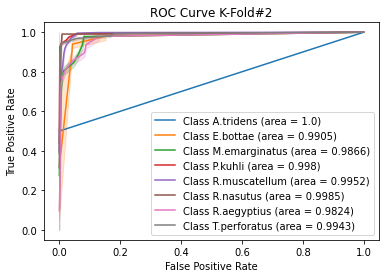

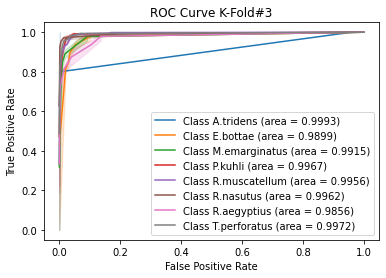

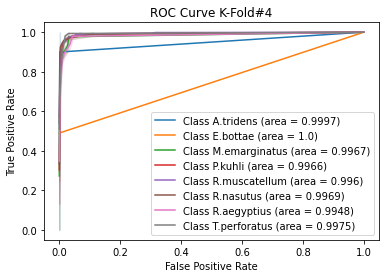

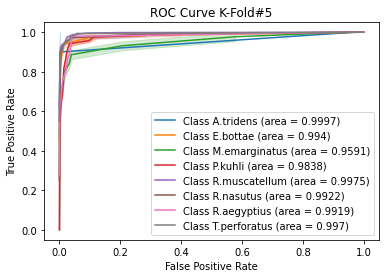

In [19]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

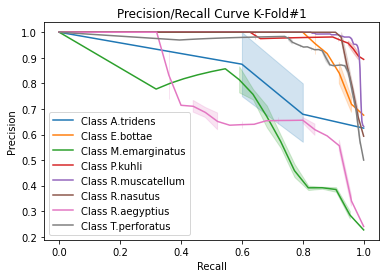

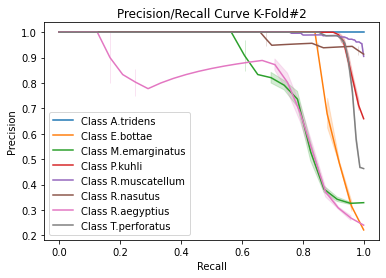

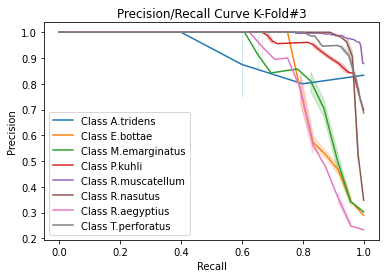

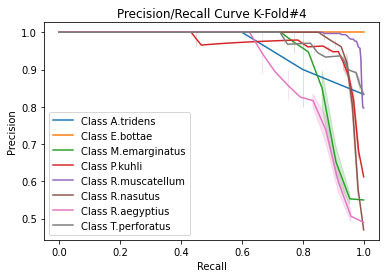

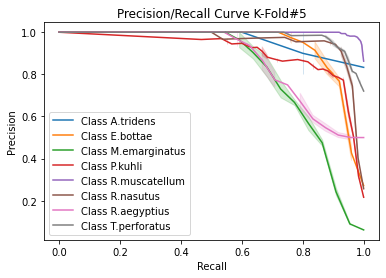

In [20]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  4   0   0   0   1   0   0   0]
 [  0  21   0   0   2   0   2   0]
 [  0   0  13   2   2   1   3   1]
 [  0   0   0  56   1   2   0   0]
 [  0   0   2   0 326   0   2   3]
 [  0   0   0   1   1  51   0   1]
 [  1   0   0   0   4   2  16   2]
 [  0   0   0   0   8   0   2  71]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  22   0   0   2   1   0   0]
 [  0   0  16   2   3   0   1   1]
 [  0   0   1  57   0   2   0   0]
 [  0   0   0   1 327   0   0   5]
 [  0   0   0   3   1  49   0   0]
 [  0   0   2   0   6   0  14   2]
 [  0   0   0   0   3   0   1  77]]


Confusion Matrix K-Fold #3

[[  3   0   0   1   0   0   0   1]
 [  0  19   0   0   5   0   0   0]
 [  0   0  19   2   1   0   0   1]
 [  0   0   1  54   1   1   0   3]
 [  0   0   1   0 328   0   1   3]
 [  0   0   1   2   0  51   0   0]
 [  0   0   1   1   4   0  16   2]
 [  0   0   0   1   2   0   0  78]]


Confusion Matrix K-Fold #4

[[  4   0   0   0   0   0   1   0]
 [  

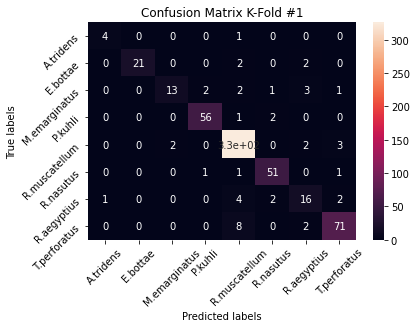

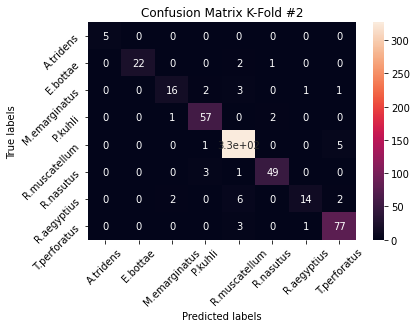

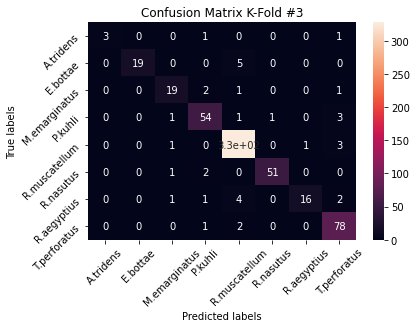

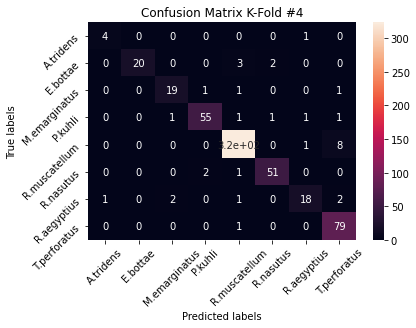

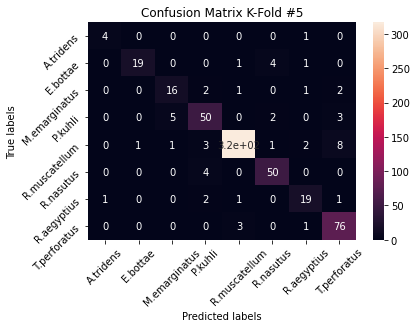

In [21]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  20    0    0    1    1    0    2    1]
 [   0  101    0    0   13    7    3    0]
 [   0    0   83    9    8    1    5    6]
 [   0    0    8  272    3    8    1    7]
 [   0    1    4    4 1622    1    6   27]
 [   0    0    1   12    3  252    0    1]
 [   3    0    5    3   16    2   83    9]
 [   0    0    0    1   17    0    4  381]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  20   0   0   2   1   0   0]
 [  0   0  16   1   1   0   1   1]
 [  0   0   1  54   0   1   0   1]
 [  0   0   0   0 324   0   1   5]
 [  0   0   0   2   0  50   0   0]
 [  0   0   1   0   3   0  16   1]
 [  0   0   0   0   3   0   0  76]]


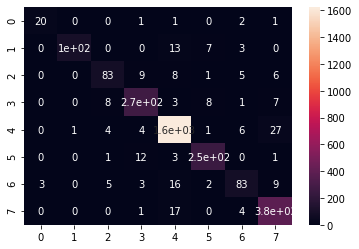

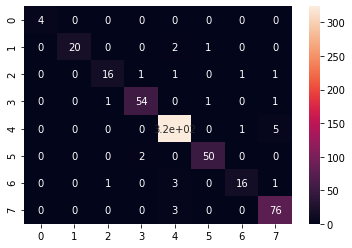

In [22]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.8  0.   0.   0.04 0.04 0.   0.08 0.04]
 [0.   0.81 0.   0.   0.1  0.06 0.02 0.  ]
 [0.   0.   0.74 0.08 0.07 0.01 0.04 0.05]
 [0.   0.   0.03 0.91 0.01 0.03 0.   0.02]
 [0.   0.   0.   0.   0.97 0.   0.   0.02]
 [0.   0.   0.   0.04 0.01 0.94 0.   0.  ]
 [0.02 0.   0.04 0.02 0.13 0.02 0.69 0.07]
 [0.   0.   0.   0.   0.04 0.   0.01 0.95]]


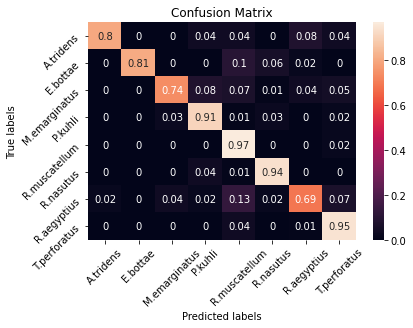

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [23]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [25]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [26]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [27]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
